In [1]:
import pandas
import seaborn
import numpy as np
from sklearn import preprocessing
import time
import math
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import spatial
import scipy
import warnings
warnings.filterwarnings('ignore')
pandas.options.display.max_rows = 7200

## Building the dataframe and pre-processing the data

In [2]:
chunk = pandas.read_csv('trips.csv', chunksize=1000000)
df = pandas.concat(chunk)
df.head(3)

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,...,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,009bff6108bdad18224f166699744a5231958c0d,11/1/2018 0:00,11/1/2018 0:15,558,2.6,1.703183e+10,1.703108e+10,7.0,8.0,7.5,...,2.5,10.0,False,1,41.914747,-87.654007,POINT (-87.6540070286 41.9147473049),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365)
1,00a86e3b5eb12b9a0f08d7021b72d144e8ba9732,11/1/2018 0:00,11/1/2018 0:15,299,1.8,NaN,NaN,75.0,75.0,5.0,...,2.5,7.5,False,1,41.689730,-87.669054,POINT (-87.6690544032 41.6897299145),41.689730,-87.669054,POINT (-87.6690544032 41.6897299145)
2,00a9c99fb790a7320fbe9208933fe75f20d68122,11/1/2018 0:00,11/1/2018 0:15,472,4.0,1.703108e+10,1.703106e+10,8.0,6.0,7.5,...,2.5,10.0,False,1,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.942585,-87.656644,POINT (-87.6566440918 41.9425851797)


### Keeping only the valuable columns

In [3]:
trips = df[['Trip ID','Trip Start Timestamp','Trip End Timestamp', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Trip Seconds']]

In [4]:
trips.shape

(1005664, 8)

### Cleaning up the data

In [5]:
trips.dropna(inplace=True)
trips.reset_index(drop=True,inplace=True)
trips.columns = trips.columns.str.replace(' ', '_').str.lower()

### Extracting time/weekdays from the timestamps, and giving them their own columns

In [6]:
trips['trip_start_timestamp'] = pandas.to_datetime(trips['trip_start_timestamp'],format = '%m/%d/%Y %H:%M')
trips['trip_end_timestamp'] = pandas.to_datetime(trips['trip_end_timestamp'],format = '%m/%d/%Y %H:%M')
trips['weekday'] = trips['trip_start_timestamp'].dt.day_name()
trips['start_time'] = trips['trip_start_timestamp'].dt.time
trips['end_time'] = trips['trip_end_timestamp'].dt.time

In [7]:
trips['trip_seconds'].replace(',',"", regex=True, inplace=True)
trip_seconds = pandas.to_numeric(trips['trip_seconds'], errors='coerce')
trips['trip_seconds'] = trip_seconds

### Using K-Means to generate neighborhood clusters/centroids and assigning the neighborhood #s to each trip's pickup location

In [8]:
clus = trips[['pickup_centroid_latitude', 'pickup_centroid_longitude']]
kmeans = KMeans(n_clusters = 72, max_iter = 300, random_state = 12345)
kmeans.fit(clus)
centroids = kmeans.cluster_centers_
neighborhoods = kmeans.labels_
trips['pickup_neighborhood'] = neighborhoods

#### Using KDTree to place each dropoff location into one of the previously generated neighborhoods

In [9]:
def do_kdtree(centroids, points):
    mytree = scipy.spatial.cKDTree(centroids)
    dist, indexes = mytree.query(points)
    return indexes
dropoff_centroid_location = list(zip(trips['dropoff_centroid_latitude'], trips['dropoff_centroid_longitude']))
dropoff_neighborhoods = do_kdtree(centroids, dropoff_centroid_location)
trips['dropoff_neighborhood'] = dropoff_neighborhoods.tolist()

### Visualizing the neighborhood centroids on a grid

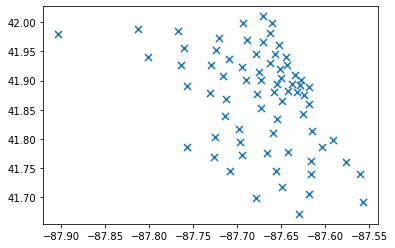

In [10]:
plt.scatter(centroids[:,1], centroids[:,0], marker='x', s=50)
plt.show()

### Visualizing the Kmeans clusters on a graphic distibution

<Figure size 1440x1152 with 0 Axes>

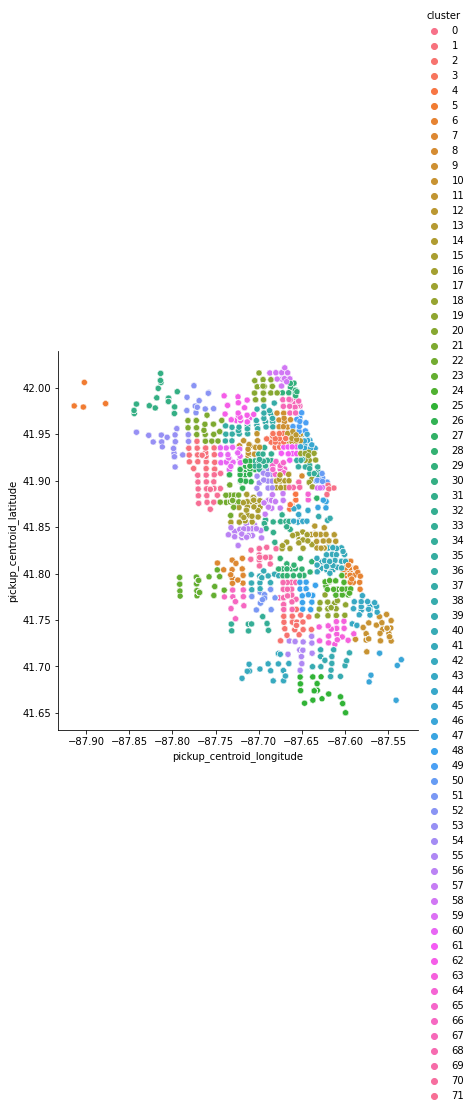

In [11]:
clus['cluster'] = kmeans.fit_predict(clus)
clus['cluster'] = clus['cluster'].astype("category")
plt.figure(figsize=(20,16))
chicago_clusters = seaborn.relplot(data=clus, x="pickup_centroid_longitude", y="pickup_centroid_latitude", hue="cluster", height=6)


### Visualizing neighborhood centroids on a map of Chicago

In [12]:
import folium
from folium import IFrame, FeatureGroup, LayerControl, Map, Marker, plugins
Chicago_coordinates = (41.895140898, -87.624255632)
chicago_map = folium.Map(location=Chicago_coordinates,
                        zoom_start=11)
#convert the array into list
centroid = centroids.tolist()
# Plotting the centroids on google map using Folium library.
for point in range(0, len(centroid)):
    folium.Marker(centroid[point], popup = centroid[point]).add_to(chicago_map)
chicago_map

In [13]:
chicago_map.save("chicago_map.html")

### Cluster centroids ranked by activity and plotted over map of Chicago

In [14]:
Chicago_coordinates = (41.895140898, -87.624255632)
chicago_map_ranked = folium.Map(location=Chicago_coordinates,
                        zoom_start=11)
#convert the array into list
centroid = centroids.tolist()
# Plotting the centroids on google map using Folium library.
for point in range(0, len(centroid)):
    folium.CircleMarker(centroid[point],radius=neighborhoods[point]/2, color='green',fill_color='green',fill_opacity=0.6, popup = centroid[point]).add_to(chicago_map_ranked)
chicago_map_ranked

In [15]:
chicago_map_ranked.save("chicago_map_ranked.html")

### Sorting the trip data by weekday, time, and pickup neighborhood to find the busiest areas

In [21]:
weekdays = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
for wd in weekdays:
    globals()[f'trips_{wd}'] = trips.groupby([trips[trips['weekday']==wd].start_time, trips[trips['weekday']==wd].pickup_neighborhood]).size()

In [22]:
Thursday = trips_Thursday.to_frame('count')
Friday = trips_Friday.to_frame('count')
Saturday = trips_Saturday.to_frame('count')
trips_Thursday_srtd = Thursday.sort_values(by=['start_time', 'count'], ascending=False)
trips_Friday_srtd = Friday.sort_values(by=['start_time', 'count'], ascending=False)
trips_Saturday_srtd = Saturday.sort_values(by=['start_time', 'count'], ascending=False)

In [23]:
trips_Friday_srtd.head(7200)

count
start_time pickup_neighborhood       
23:45:00   59.0                   307
           4.0                    285
           14.0                   212
           12.0                   198
           50.0                   188
           18.0                   161
           32.0                   160
           65.0                   157
           0.0                    156
           34.0                   154
           45.0                   149
           17.0                   148
           61.0                   130
           47.0                   125
           44.0                   107
           35.0                    99
           69.0                    89
           8.0                     87
           11.0                    81
           5.0                     80
           49.0                    80
           64.0                    79
           67.0                    78
           3.0                     76
           27.0                    73
           54.0                    61
           38.0                    58
           6.0                     53
           9.0                     47
           37.0                    46
           13.0                    40
           26.0                    38
           29.0                    32
           43.0                    31
           24.0                    28
           62.0                    28
           20.0                    27
           36.0                    27
           41.0                    25
           1.0                     23
           60.0                    23
           16.0                    22
           57.0                    22
           58.0                    22
           23.0                    21
           31.0                    20
           15.0                    19
           71.0                    18
           21.0                    17
           56.0                    17
           63.0                    17
           42.0                    14
           28.0                    13
           70.0                    13
           19.0                    12
           2.0                     11
           68.0                    11
           48.0                    10
           51.0                    10
           52.0                    10
           66.0                    10
           40.0                     9
           53.0                     9
           39.0                     8
           55.0                     8
           7.0                      7
           30.0                     6
           10.0                     5
           25.0                     4
           33.0                     3
           22.0                     2
           46.0                     2
23:30:00   59.0                   362
           4.0                    347
           14.0                   240
           50.0                   214
           12.0                   180
           0.0                    172
           34.0                   170
           18.0                   163
           65.0                   151
           32.0                   145
           61.0                   138
           17.0                   137
           45.0                   134
           69.0                   110
           5.0                    109
           47.0                   106
           64.0                    94
           35.0                    93
           11.0                    90
           44.0                    84
           27.0                    82
           67.0                    81
           3.0                     79
           49.0                    72
           37.0                    58
           6.0                     53
           8.0                     52
           54.0                    52
           26.0                    50
           38.0                    47
           31.0                    44
           9.0                     43
    

### Normalizing the data (Just Friday for now)

In [24]:
friday_nrml = trips_Friday_srtd.groupby('start_time').transform(lambda x: (x - x.min()) / (x.max() - x.min()))
friday_nrml

count
start_time pickup_neighborhood          
23:45:00   59.0                 1.000000
           4.0                  0.927869
           14.0                 0.688525
           12.0                 0.642623
           50.0                 0.609836
           18.0                 0.521311
           32.0                 0.518033
           65.0                 0.508197
           0.0                  0.504918
           34.0                 0.498361
           45.0                 0.481967
           17.0                 0.478689
           61.0                 0.419672
           47.0                 0.403279
           44.0                 0.344262
           35.0                 0.318033
           69.0                 0.285246
           8.0                  0.278689
           11.0                 0.259016
           5.0                  0.255738
           49.0                 0.255738
           64.0                 0.252459
           67.0                 0.249180
           3.0                  0.242623
           27.0                 0.232787
           54.0                 0.193443
           38.0                 0.183607
           6.0                  0.167213
           9.0                  0.147541
           37.0                 0.144262
           13.0                 0.124590
           26.0                 0.118033
           29.0                 0.098361
           43.0                 0.095082
           24.0                 0.085246
           62.0                 0.085246
           20.0                 0.081967
           36.0                 0.081967
           41.0                 0.075410
           1.0                  0.068852
           60.0                 0.068852
           16.0                 0.065574
           57.0                 0.065574
           58.0                 0.065574
           23.0                 0.062295
           31.0                 0.059016
           15.0                 0.055738
           71.0                 0.052459
           21.0                 0.049180
           56.0                 0.049180
           63.0                 0.049180
           42.0                 0.039344
           28.0                 0.036066
           70.0                 0.036066
           19.0                 0.032787
           2.0                  0.029508
           68.0                 0.029508
           48.0                 0.026230
           51.0                 0.026230
           52.0                 0.026230
           66.0                 0.026230
           40.0                 0.022951
           53.0                 0.022951
           39.0                 0.019672
           55.0                 0.019672
           7.0                  0.016393
           30.0                 0.013115
           10.0                 0.009836
           25.0                 0.006557
           33.0                 0.003279
           22.0                 0.000000
           46.0                 0.000000
23:30:00   59.0                 1.000000
           4.0                  0.958449
           14.0                 0.662050
           50.0                 0.590028
           12.0                 0.495845
           0.0                  0.473684
           34.0                 0.468144
           18.0                 0.448753
           65.0                 0.415512
           32.0                 0.398892
           61.0                 0.379501
           17.0                 0.376731
           45.0                 0.368421
           69.0                 0.301939
           5.0                  0.299169
           47.0                 0.290859
           64.0                 0.257618
           35.0                 0.254848
           11.0                 0.246537
           44.0                 0.229917
           27.0                 0.224377
           67.0                 0.221607
           3.0                  0.216066
           49.0                 0.196676
           37.0  

## Recommendation Algorithm

In [25]:
def first_fare_finder(trips):
    # for testing purposes, we find a random fare that starts during rush hour, downtown, on Friday
    first_fare = trips[trips['start_time']==(datetime.time(17,0))]
    first_fare = first_fare[first_fare['pickup_neighborhood'] == 12]
    first_fare = first_fare[first_fare['weekday'] == 'Friday']
    first_fare = first_fare.sample(n=1)
    return first_fare

In [26]:
def fare_rec(candidates, current):
    # take candidate fares and assign them scores based on their dropoff location and the time-length of the trip
    candidates['trip_length_score'] = candidates['trip_seconds'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    for i, row in candidates.iterrows():
        candidates.at[i, 'drop_loc_score'] = (friday_nrml.loc[row['end_time'], row['dropoff_neighborhood']][0] * 2)
    for i, row in candidates.iterrows():
        candidates.at[i, 'total_score'] = (row['drop_loc_score'] + row['trip_length_score'])
    next_fare = candidates.iloc[candidates['total_score'].idxmax()]
    return next_fare, candidates

In [27]:
def candidate_shuffler(trips, current):
    # generate new candidate fares
    candidates = trips[trips['start_time'] == current.iloc[0]['end_time']]
    candidates = candidates[candidates['pickup_neighborhood'] == current.iloc[0]['dropoff_neighborhood']]
    candidates = candidates[candidates['weekday'] == current.iloc[0]['weekday']]
    candidates = candidates.sample(n=20)
    candidates.reset_index(inplace=True)
    return candidates

## Testing the algorithm

In [28]:
first = first_fare_finder(trips)
first

,trip_id,trip_start_timestamp,trip_end_timestamp,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_seconds,weekday,start_time,end_time,pickup_neighborhood,dropoff_neighborhood,day_a_week
405404,92967add2770a205285e48d3f3a62602b558c63c,2018-11-02 17:00:00,2018-11-02 17:00:00,41.94914,-87.656804,41.941422,-87.675954,433,Friday,17:00:00,17:00:00,12,3,4


In [29]:
candidates = candidate_shuffler(trips,first)
candidates

,index,trip_id,trip_start_timestamp,trip_end_timestamp,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_seconds,weekday,start_time,end_time,pickup_neighborhood,dropoff_neighborhood,day_a_week
0,406944,b927c9cae1d8a8cda627b021e1b46eb390883fab,2018-11-02 17:00:00,2018-11-02 17:00:00,41.941366,-87.680827,41.963374,-87.670185,604,Friday,17:00:00,17:00:00,3,9,4
1,408162,c6a15c6d28a8409de03af9e89373a27b1bdf0ed8,2018-11-02 17:00:00,2018-11-02 17:00:00,41.945069,-87.676063,41.957652,-87.691530,554,Friday,17:00:00,17:00:00,3,37,4
2,407224,187b09986175b94373a77e89ba80fe088a5ad4b8,2018-11-02 17:00:00,2018-11-02 17:00:00,41.950605,-87.671332,41.941488,-87.671108,224,Friday,17:00:00,17:00:00,3,3,4
3,404927,64270e887b4be2aa4dc0d8cf0a4dc540cca903bb,2018-11-02 17:00:00,2018-11-02 17:15:00,41.945010,-87.680928,41.945170,-87.668794,321,Friday,17:00:00,17:15:00,3,3,4
4,407510,4f6fffd3d451638bb55d27229af8d53baf6303c8,2018-11-02 17:00:00,2018-11-02 17:15:00,41.935749,-87.680980,41.949221,-87.651970,892,Friday,17:00:00,17:15:00,3,12,4
5,404110,0eb9e011ed90d1c3bb57f9b161a64df00cd1ec3c,2018-11-02 17:00:00,2018-11-02 17:15:00,41.941488,-87.671108,41.987226,-87.664938,1246,Friday,17:00:00,17:15:00,3,67,4
6,407187,131ca512bbd4da3001814af1368903f5a9482835,2018-11-02 17:00:00,2018-11-02 17:15:00,41.950605,-87.671332,41.942692,-87.651771,340,Friday,17:00:00,17:15:00,3,12,4
7,407541,559c582fe5be8c42d193cf31e4dab42cdd083041,2018-11-02 17:00:00,2018-11-02 17:45:00,41.945010,-87.680928,42.009018,-87.672724,2065,Friday,17:00:00,17:45:00,3,58,4
8,404563,40a8fea0429a229826f8ac8635896bf686f39ce6,2018-11-02 17:00:00,2018-11-02 17:15:00,41.935984,-87.675822,41.957736,-87.683718,567,Friday,17:00:00,17:15:00,3,37,4
9,406377,f370080031ca705f18fae667438074442b6564fb,2018-11-02 17:00:00,2018-11-02 17:30:00,41.945010,-87.680928,41.856333,-87.659564,1852,Friday,17:00:00,17:30:00,3,44,4


In [30]:
recd_fare, candidates_with_scores = fare_rec(candidates, first)

In [31]:
recd_fare

index                                                           407070
trip_id                       00a7ec41bbe16b7ea1e0b1e0de2f79858a120de7
trip_start_timestamp                               2018-11-02 17:00:00
trip_end_timestamp                                 2018-11-02 17:30:00
pickup_centroid_latitude                                     41.944814
pickup_centroid_longitude                                   -87.690775
dropoff_centroid_latitude                                    41.884987
dropoff_centroid_longitude                                  -87.620993
trip_seconds                                                      2189
weekday                                                         Friday
start_time                                                    17:00:00
end_time                                                      17:30:00
pickup_neighborhood                                                  3
dropoff_neighborhood                                                 0
day_a_

In [32]:
candidates_with_scores.sort_values(by='total_score', ascending=False)

,index,trip_id,trip_start_timestamp,trip_end_timestamp,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_seconds,weekday,start_time,end_time,pickup_neighborhood,dropoff_neighborhood,day_a_week,trip_length_score,drop_loc_score,total_score
12,407070,00a7ec41bbe16b7ea1e0b1e0de2f79858a120de7,2018-11-02 17:00:00,2018-11-02 17:30:00,41.944814,-87.690775,41.884987,-87.620993,2189,Friday,17:00:00,17:30:00,3,0,4,0.915657,1.703883,2.619541
10,404328,27205e656b77218589147eedfac170f0664810bb,2018-11-02 17:00:00,2018-11-02 17:45:00,41.950443,-87.683506,41.892508,-87.626215,2370,Friday,17:00:00,17:45:00,3,59,4,1.000000,1.310000,2.310000
9,406377,f370080031ca705f18fae667438074442b6564fb,2018-11-02 17:00:00,2018-11-02 17:30:00,41.945010,-87.680928,41.856333,-87.659564,1852,Friday,17:00:00,17:30:00,3,44,4,0.758621,0.475728,1.234349
16,406701,15c2d70ab848715213ed18de61a52bd23c21b1aa,2018-11-02 17:00:00,2018-11-02 17:45:00,41.935749,-87.680980,41.949709,-87.752118,2369,Friday,17:00:00,17:45:00,3,21,4,0.999534,0.140000,1.139534
7,407541,559c582fe5be8c42d193cf31e4dab42cdd083041,2018-11-02 17:00:00,2018-11-02 17:45:00,41.945010,-87.680928,42.009018,-87.672724,2065,Friday,17:00:00,17:45:00,3,58,4,0.857875,0.145000,1.002875
19,406126,dc75c7b777eec0ac89f16c6756152e828c812bf7,2018-11-02 17:00:00,2018-11-02 17:30:00,41.944814,-87.690775,41.904935,-87.649907,1537,Friday,17:00:00,17:30:00,3,8,4,0.611836,0.233010,0.844846
5,404110,0eb9e011ed90d1c3bb57f9b161a64df00cd1ec3c,2018-11-02 17:00:00,2018-11-02 17:15:00,41.941488,-87.671108,41.987226,-87.664938,1246,Friday,17:00:00,17:15:00,3,67,4,0.476235,0.308943,0.785178
13,406768,42e2ed0462c9610a5e069565c3f5ac6b0df84346,2018-11-02 17:00:00,2018-11-02 17:15:00,41.950605,-87.671332,41.929273,-87.673807,579,Friday,17:00:00,17:15:00,3,61,4,0.165424,0.569106,0.734530
4,407510,4f6fffd3d451638bb55d27229af8d53baf6303c8,2018-11-02 17:00:00,2018-11-02 17:15:00,41.935749,-87.680980,41.949221,-87.651970,892,Friday,17:00:00,17:15:00,3,12,4,0.311277,0.357724,0.669000
11,406041,d2ece17600f711b60ca0d6ab91c4659e040f217f,2018-11-02 17:00:00,2018-11-02 17:15:00,41.945069,-87.676063,42.009018,-87.672724,1138,Friday,17:00:00,17:15:00,3,58,4,0.425909,0.205962,0.631871
